# 1. 전복 데이터를 이용하여 머신러닝 5가지 분류 수행(SVM, LR, RF, DT, KNN)

In [2]:
from os import X_OK
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import warnings

In [3]:
df = pd.read_csv("C:\\Users\\akasa\\Downloads\\abalone.csv", index_col=0)
df

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9


In [4]:
# 결측치 확인
df.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

C:\Users\akasa\AppData\Local\Temp\ipykernel_25304\2498552643.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax)


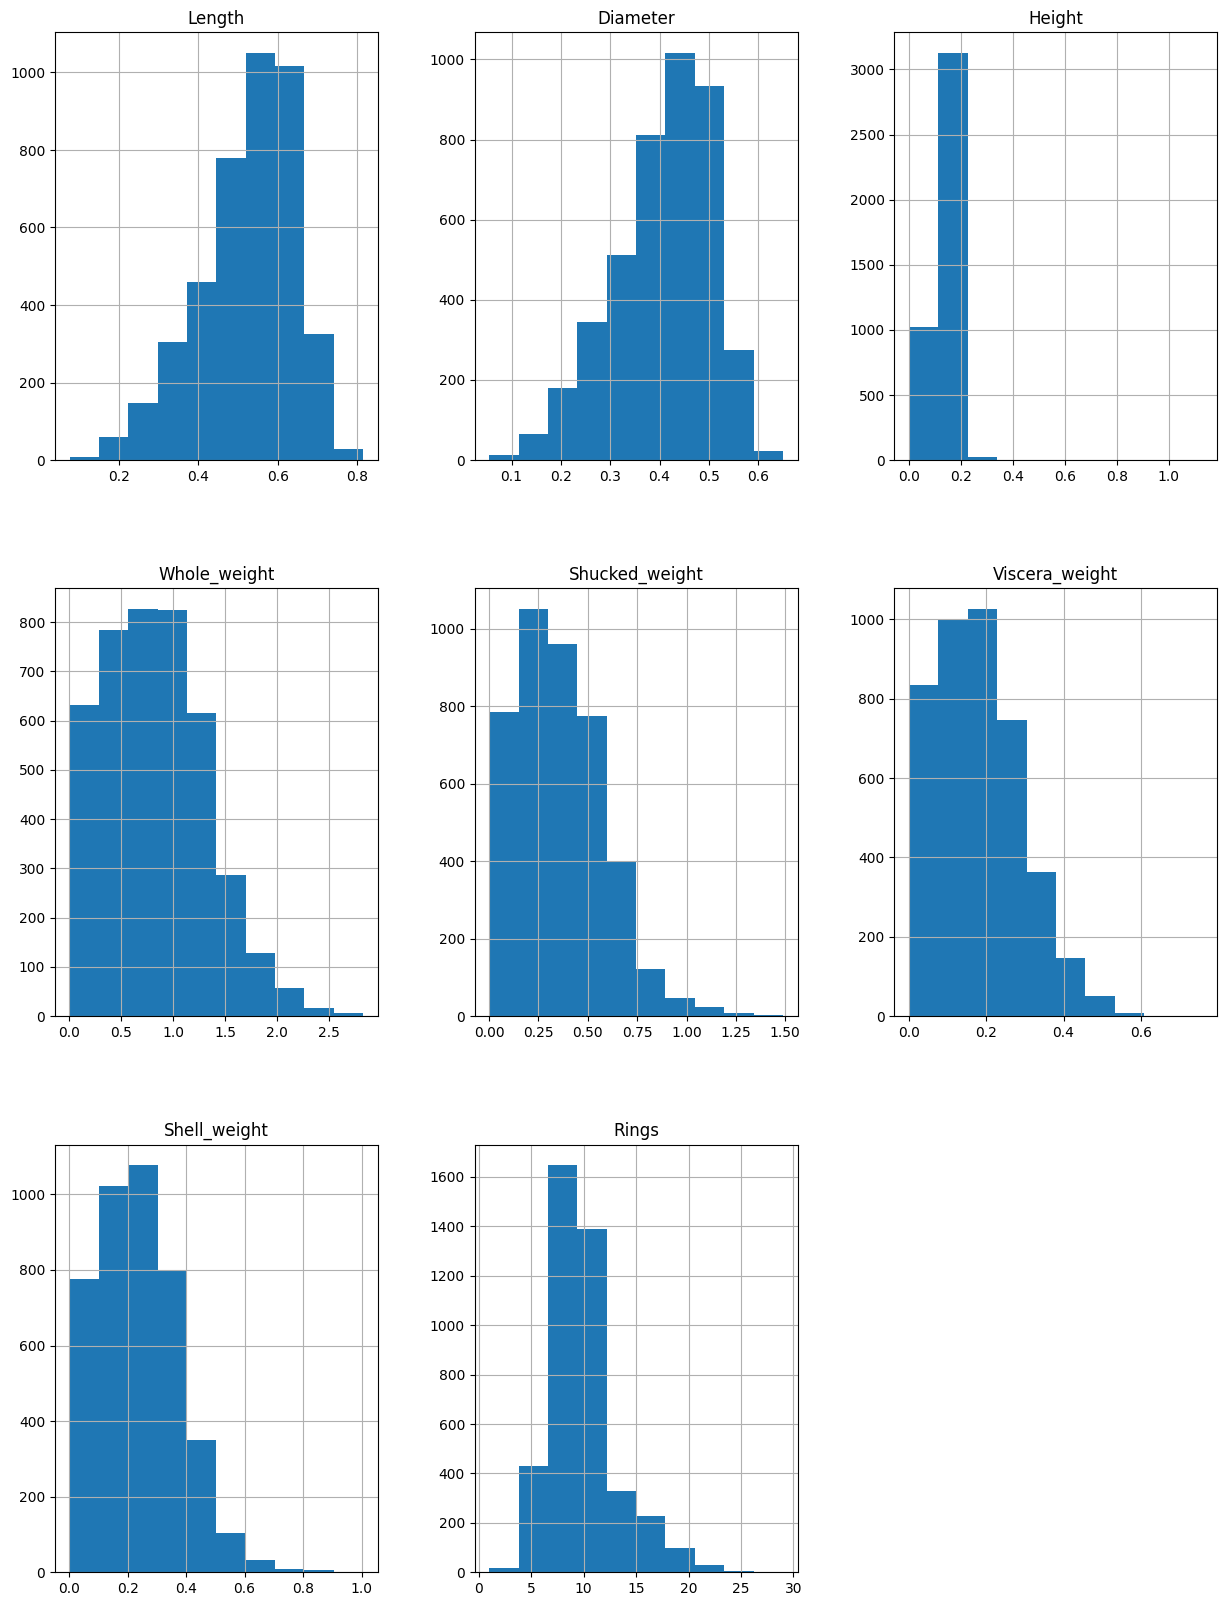

In [5]:
# 각 컬럼별 히스토 그램 확인

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

In [6]:
#방법 2 : Sex label만 정수형으로 label encoding

target_label = df['Sex']
target_label.dtype
mapping = {'M':0, 'F':1,'I':2}
df['Sex'] = target_label.map(mapping)
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,,
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [7]:
import numpy as np
import pandas as pd

def remove_outliers(data, column):
    # 사분위수를 이용해 이상치 제거
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1  # IQR: Interquartile Range (사분위 범위)
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # 이상치가 아닌 데이터만 필터링
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data


In [8]:
# labels = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

df_cleaned = remove_outliers(df,df.columns)
# df_cleaned

In [9]:
# 레이블 갯수 확인 (숫자)
df_cleaned['Rings'].value_counts()

Rings
9.0     689
10.0    634
8.0     568
11.0    487
7.0     391
12.0    267
6.0     259
13.0    203
14.0    126
5.0     115
15.0    103
4.0      57
Name: count, dtype: int64

In [10]:
# 결측치 제거
df_cleaned = df_cleaned.dropna()
df_cleaned.isnull().sum()

Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64

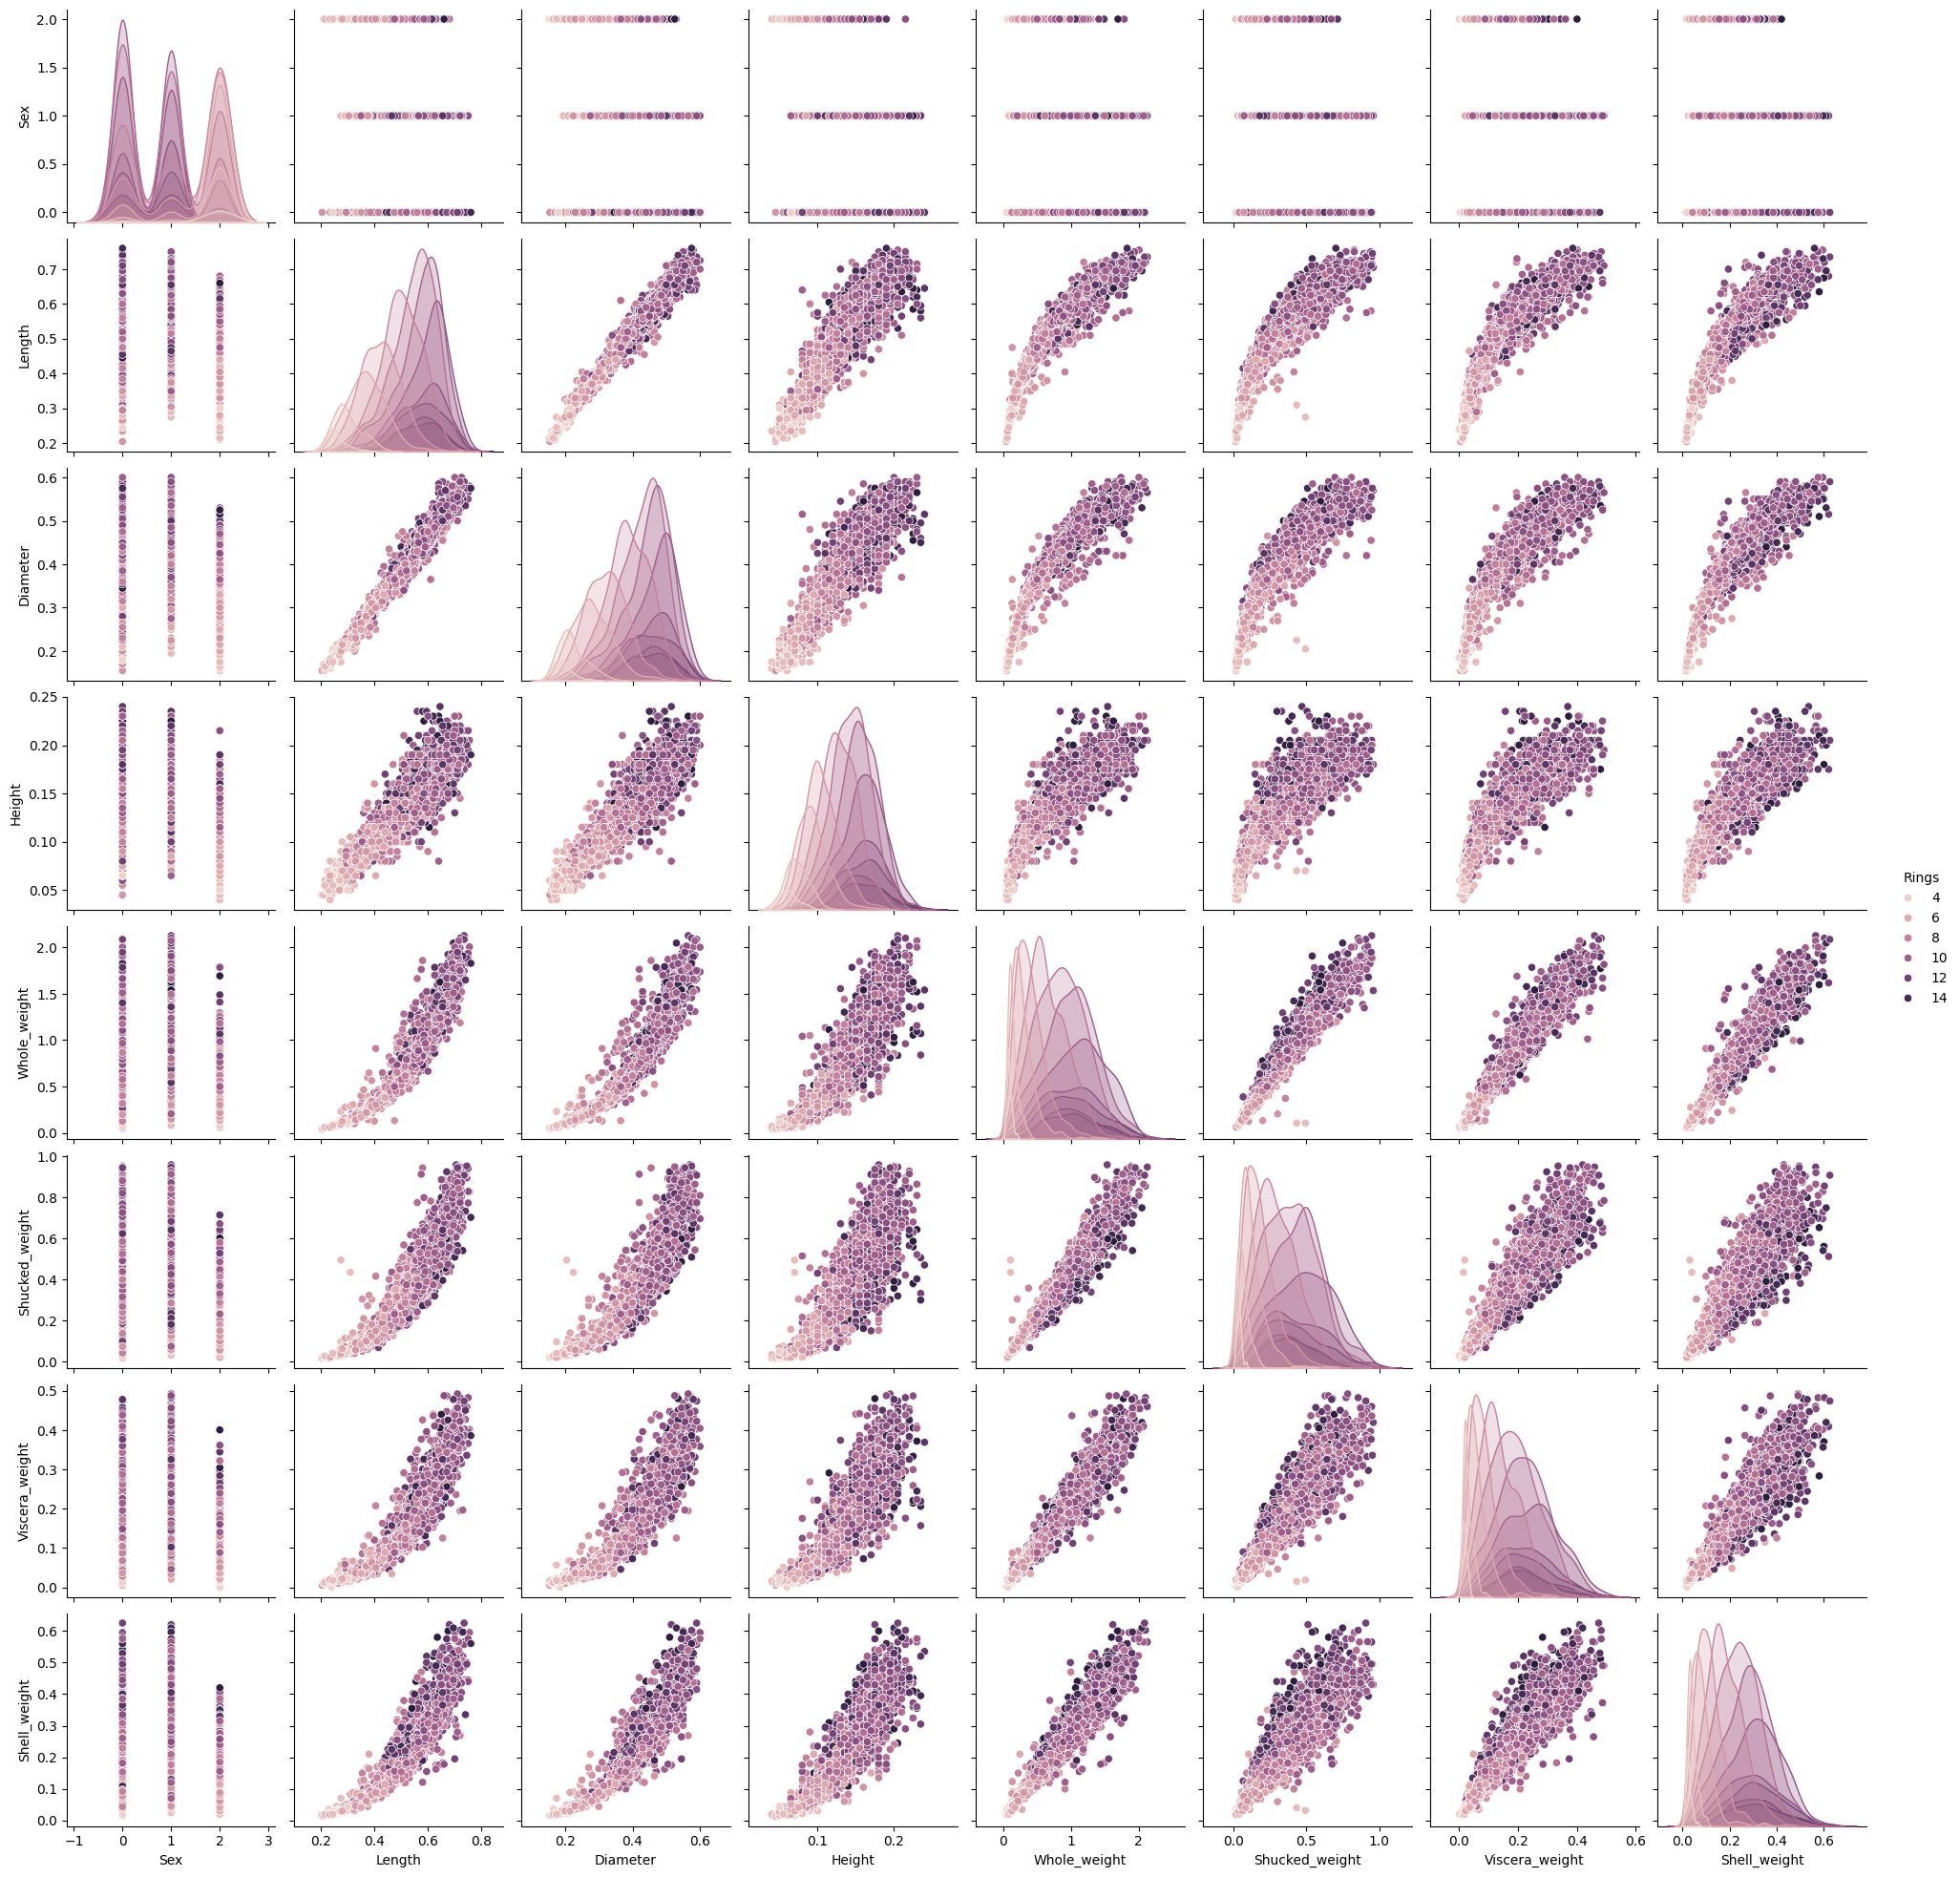

In [11]:
# pairplot를 사용해 각 상관관계 살펴보기

sns.pairplot(df_cleaned,
             vars=['Sex','Length',	'Diameter',	'Height','Whole_weight',	'Shucked_weight',	'Viscera_weight',	'Shell_weight'],
            hue ='Rings')
plt.show()

In [12]:
data = df_cleaned[(df_cleaned['Rings'] >= 3) & (df_cleaned['Rings'] <= 23)]

# Rings의 고유한 값들을 0부터 시작하는 인덱스로 재매핑
unique_rings = sorted(data['Rings'].unique())  # 고유한 값들을 정렬
encoding_map = {ring: idx for idx, ring in enumerate(unique_rings)}  # 재매핑

# 인코딩 적용
df_cleaned['Rings'] =data['Rings'].map(encoding_map)

Text(0.5, 1.0, 'abalone ring count')

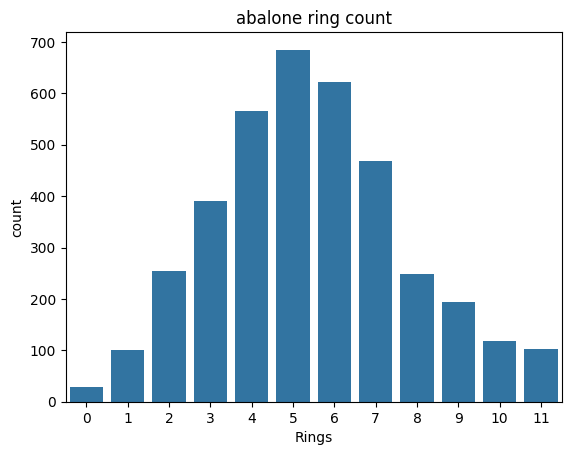

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 레이블 갯수 확인 (그래프)
sns.countplot(data = df_cleaned, x="Rings")
plt.xlabel("Rings")
plt.ylabel("count")
plt.title("abalone ring count")

C:\Users\akasa\AppData\Local\Temp\ipykernel_25304\3558328370.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_cleaned.hist(ax = ax)


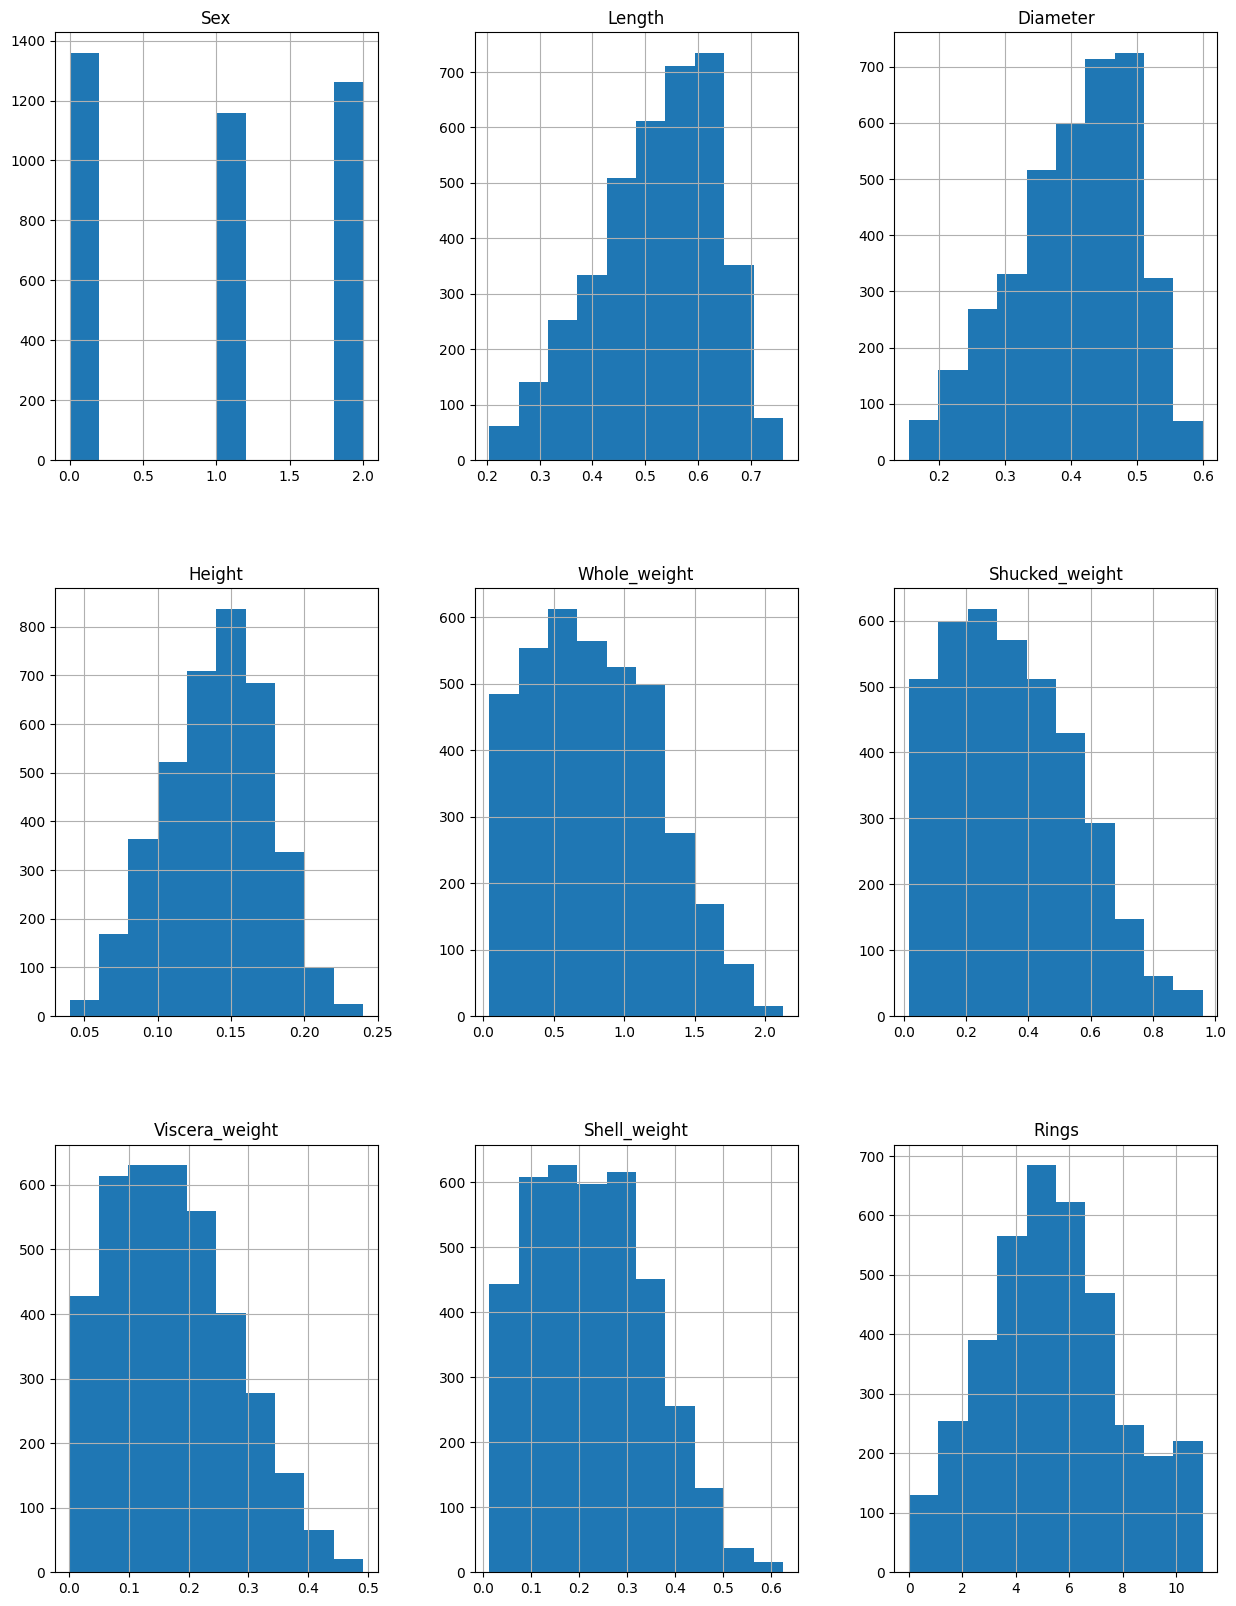

In [14]:
# 각 컬럼별 히스토 그램 확인

fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_cleaned.hist(ax = ax)
plt.show()

In [15]:
df_cleaned['Viscera_weight'].value_counts().unique()

array([15, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1],
      dtype=int64)

Text(0.5, 1.0, 'abalone Viscera_weight count')

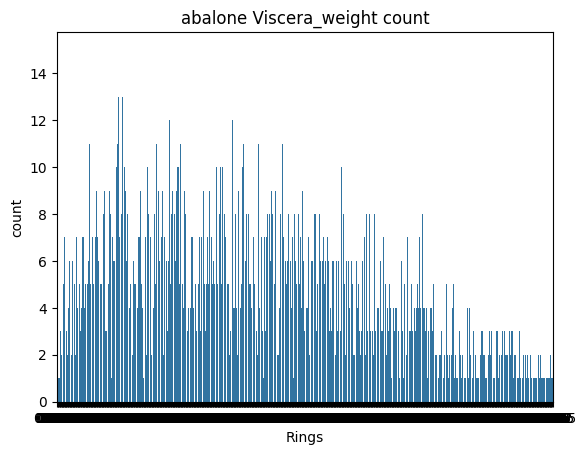

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# 레이블 갯수 확인 (그래프)
sns.countplot(data = df_cleaned, x="Viscera_weight")
plt.xlabel("Rings")
plt.ylabel("count")
plt.title("abalone Viscera_weight count")

Text(0.5, 1.0, 'abalone Height count')

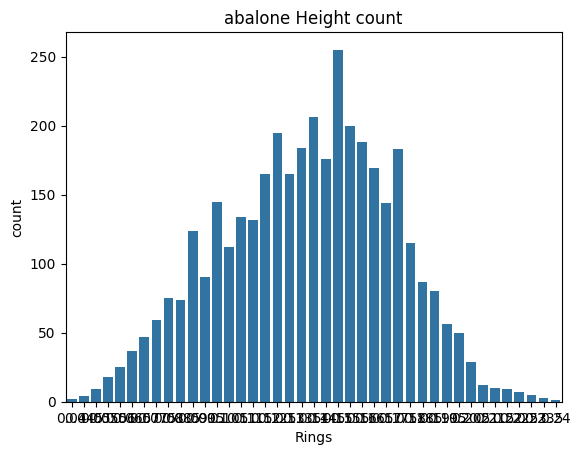

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# 레이블 갯수 확인 (그래프)
sns.countplot(data = df_cleaned, x="Height")
plt.xlabel("Rings")
plt.ylabel("count")
plt.title("abalone Height count")

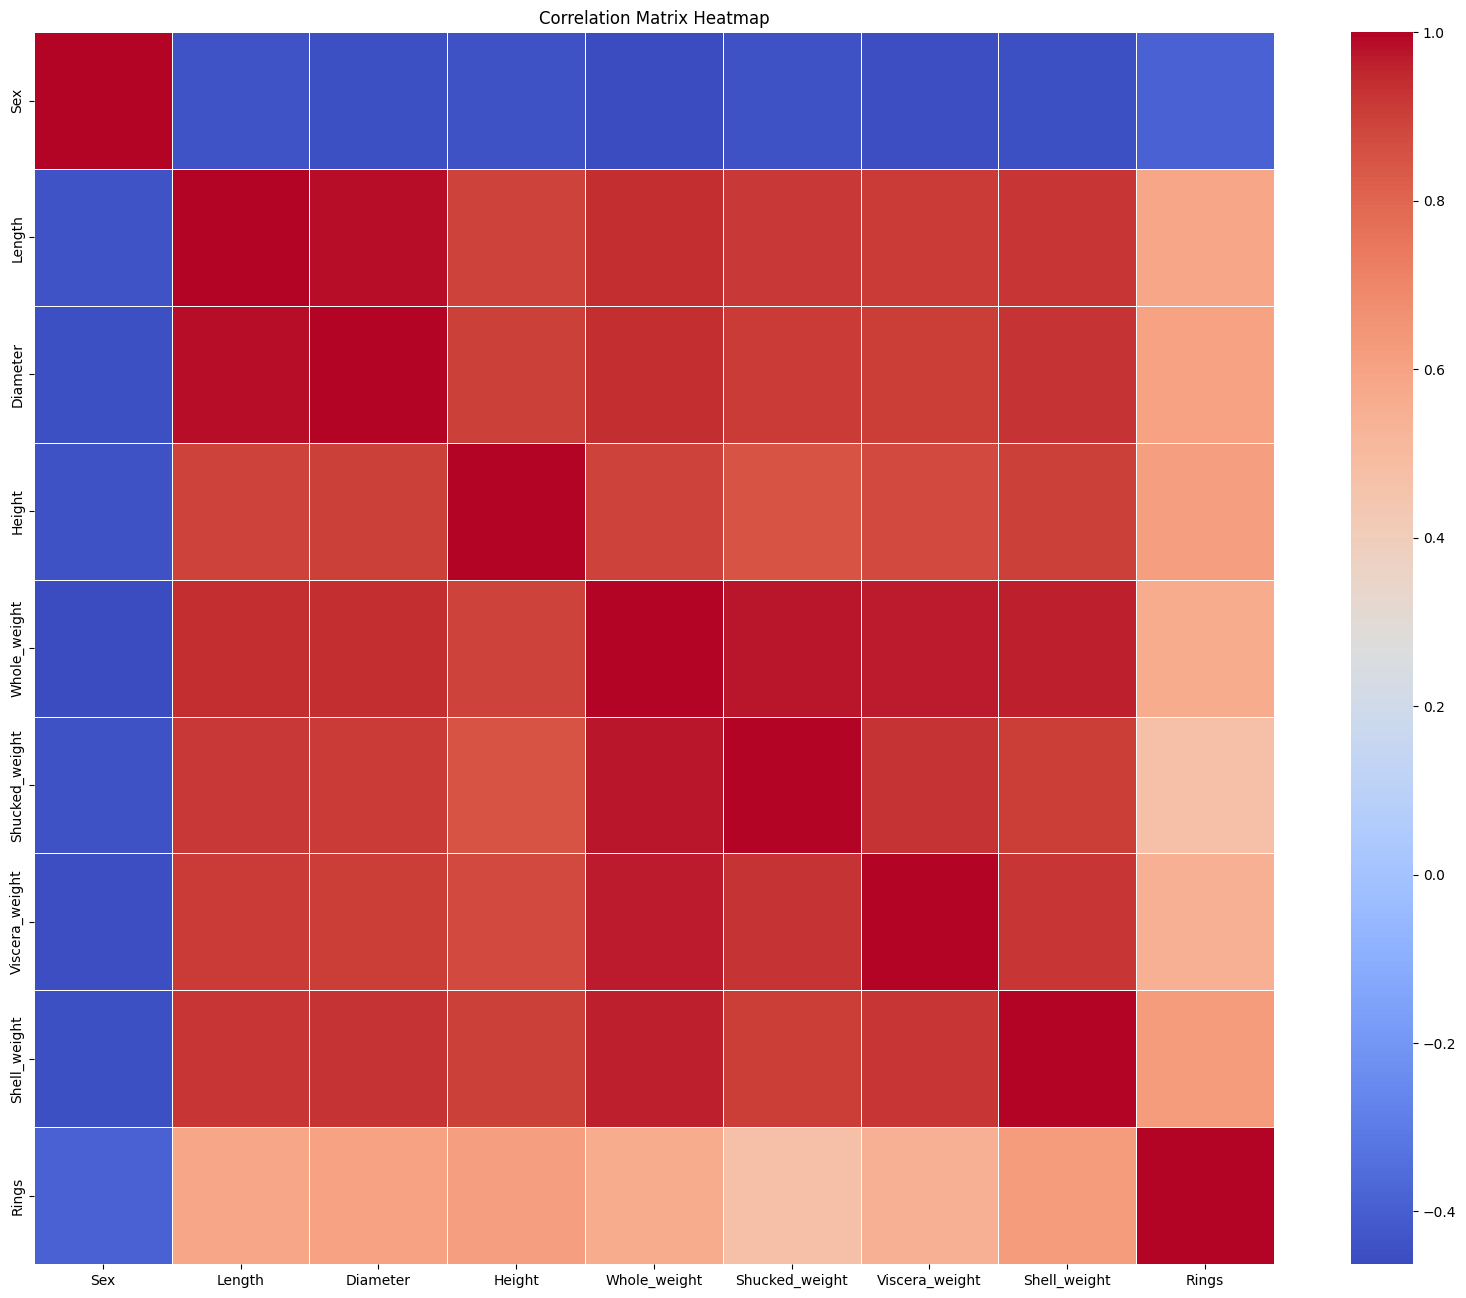

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_cleaned.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [19]:
df_cleaned.drop('Sex',axis=1)

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
id,,,,,,,,
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,11
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,3
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,5
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,6
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,3
...,...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,7
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,6
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,5


In [20]:
X=df_cleaned.drop('Rings',axis=1)
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
id,,,,,,,,
0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,2,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [21]:
y=df_cleaned['Rings']
y.value_counts()

Rings
5     685
6     623
4     566
7     469
3     391
2     254
8     248
9     195
10    118
11    102
1     101
0      29
Name: count, dtype: int64

In [22]:
print ("==================================")
print (" ACCURACY OF OTHER ML CLASSIFIERS" )
print ("==================================")

 ACCURACY OF OTHER ML CLASSIFIERS


In [23]:
# # 범주형 데이터 인코딩 (One-Hot Encoding)
# categorical_features = ['Sex']
# numerical_features = ['Sex','Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']

# # 전처리 파이프라인 설정
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numerical_features),  # 수치형 데이터 스케일링
#         ('cat', OneHotEncoder(), categorical_features)  # 범주형 데이터 원핫 인코딩
#     ])

In [24]:
def categorize_rings(rings):
    if rings <= 10:
        return 0  # 클래스 0
    else:
        return 2  # 클래스 1

# Rings 컬럼에 범주형 변환 적용
y_categorized = df_cleaned['Rings'].apply(categorize_rings)

In [25]:
preprocessor = StandardScaler()
# 데이터 전처리 및 분할 (이전과 동일한 방식)
X_processed = preprocessor.fit_transform(X)

# 데이터를 훈련+검증 세트와 테스트 세트로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(X_processed, y_categorized, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 나누기
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [26]:
#SVM
clf_svm = SVC(random_state=0)
clf_svm.fit(X_train, y_train)

pred_svm = clf_svm.predict(X_test)

print("\n--- SVM Classifier ---")
print(accuracy_score(y_test, pred_svm))
print(confusion_matrix(y_test, pred_svm))


--- SVM Classifier ---
0.9749009247027741
[[738   0]
 [ 19   0]]


In [27]:
# Build a logistic regression classifier and predict

clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)

pred_lr = clf_lr.predict(X_test)

print ("\n--- Logistic Regression Classifier ---")
print (accuracy_score(y_test, pred_lr))
print (confusion_matrix(y_test, pred_lr))


--- Logistic Regression Classifier ---
0.9735799207397622
[[737   1]
 [ 19   0]]


In [28]:
clf_nn = MLPClassifier(random_state=0)
clf_nn.fit(X_train, y_train)

#NN
pred_nn = clf_nn.predict(X_test)

print ("\n--- Neural Network Classifier ---")
print (accuracy_score(y_test, pred_nn))
print (confusion_matrix(y_test, pred_nn))


--- Neural Network Classifier ---
0.9722589167767504
[[736   2]
 [ 19   0]]


C:\Users\akasa\anaconda3\envs\DLA\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
# Build a decision tree classifier and predict

clf_dt = DecisionTreeClassifier(random_state=0)
clf_dt.fit(X_train, y_train)

pred_dt = clf_dt.predict(X_test)

print ("\n--- Decision Tree Classifier ---")
print (accuracy_score(y_test, pred_dt))
print (confusion_matrix(y_test, pred_dt))

warnings.filterwarnings('ignore')


--- Decision Tree Classifier ---
0.9498018494055482
[[718  20]
 [ 18   1]]


In [30]:
#Random forest
print ("\n--- Radom Forest ---")
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
print(accuracy_score(y_test,pred))
print (confusion_matrix(y_test, pred))


--- Radom Forest ---
0.9749009247027741
[[738   0]
 [ 19   0]]


# 2. 딥러닝 수행하기

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.callbacks import EarlyStopping


In [33]:
def categorize_rings_three(rings):
    if rings <= 4:
        return 0  # 클래스 0
    elif(rings < 7):
        return 1  # 클래스 1
    else:
        return 2

preprocessor = StandardScaler()
# 데이터 전처리 및 분할 (이전과 동일한 방식)
X_processed = preprocessor.fit_transform(X)

# Rings 컬럼에 범주형 변환 적용
y_categorized = df_cleaned['Rings'].apply(categorize_rings_three)

In [34]:
y_categorized.value_counts()

Rings
0    1341
1    1308
2    1132
Name: count, dtype: int64

In [35]:
from tensorflow.keras.utils import to_categorical

# 타겟을 One-Hot Encoding으로 변환한 후 reshape
y_categorized = to_categorical(y_categorized, num_classes=3)

In [36]:
y_categorized

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [37]:
print(np.unique(y_categorized))

[0. 1.]


In [38]:
y_raw = df_cleaned['Rings'].apply(categorize_rings_three)
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y_categorized, test_size=0.2, random_state=42,stratify=y_raw)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 나누기
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42,stratify=y_temp) 

In [39]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3024, 3)
(378, 3)
(379, 3)


In [40]:
# y_categorized가 원핫 인코딩된 상태라면, argmax로 원래 범주형 값으로 변환
y_train_classes = np.argmax(y_train, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 각 데이터셋에 클래스 분포 확인
print(np.unique(y_train_classes, return_counts=True))
print(np.unique(y_val_classes, return_counts=True))
print(np.unique(y_test_classes, return_counts=True))

(array([0, 1, 2], dtype=int64), array([1073, 1046,  905], dtype=int64))
(array([0, 1, 2], dtype=int64), array([134, 131, 114], dtype=int64))
(array([0, 1, 2], dtype=int64), array([134, 131, 113], dtype=int64))


Epoch 1/500
24/24 [==============================] - 2s 36ms/step - loss: 1.4256 - accuracy: 0.4861 - val_loss: 1.2854 - val_accuracy: 0.5198
Epoch 2/500
24/24 [==============================] - 0s 5ms/step - loss: 1.2390 - accuracy: 0.5470 - val_loss: 1.1164 - val_accuracy: 0.6121
Epoch 3/500
24/24 [==============================] - 0s 6ms/step - loss: 1.1314 - accuracy: 0.5764 - val_loss: 1.0460 - val_accuracy: 0.6412
Epoch 4/500
24/24 [==============================] - 0s 6ms/step - loss: 1.0689 - accuracy: 0.5939 - val_loss: 0.9890 - val_accuracy: 0.6438
Epoch 5/500
24/24 [==============================] - 0s 6ms/step - loss: 1.0188 - accuracy: 0.6065 - val_loss: 0.9477 - val_accuracy: 0.6544
Epoch 6/500
24/24 [==============================] - 0s 7ms/step - loss: 0.9760 - accuracy: 0.6144 - val_loss: 0.9127 - val_accuracy: 0.6728
Epoch 7/500
24/24 [==============================] - 0s 7ms/step - loss: 0.9458 - accuracy: 0.6111 - val_loss: 0.8887 - val_accuracy: 0.6280
Epoch 8/500


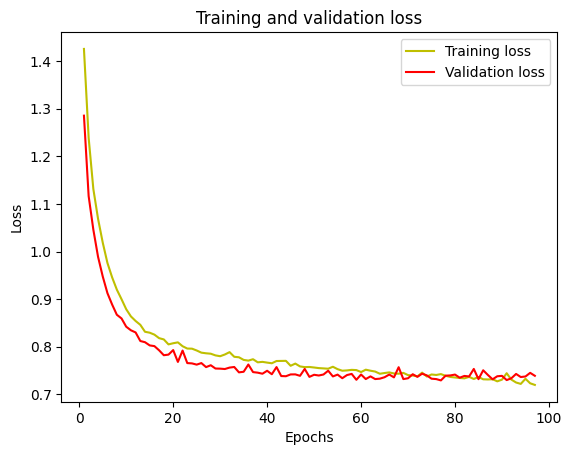

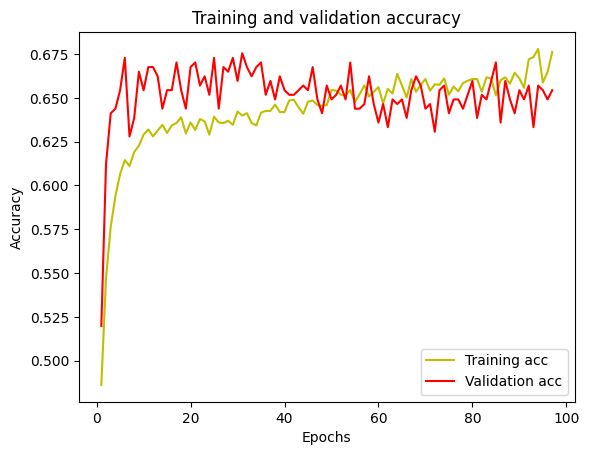

최종 훈련 정확도 : 0.6763
최종 검증 정확도 : 0.6544
테스트 세트 정확도 : 0.6693


In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    #Dropout(0.4),
    Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    #Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dense(3, activation='softmax')
])

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model_history = model.fit(x=X_train, y=y_train, epochs=500, batch_size=128, validation_data=(X_val, y_val), callbacks=early_stopping)
# 모델 예측
y_pred = model.predict(X_test)

# 손실 그래프 시각화
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 정확도 그래프 시각화
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 최종 정확도 출력
train_acc = model_history.history['accuracy'][-1]
val_acc = model_history.history['val_accuracy'][-1]
print(f"최종 훈련 정확도 : {train_acc:.4f}")
print(f"최종 검증 정확도 : {val_acc:.4f}")

# 테스트 데이터 평가
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 세트 정확도 : {test_acc:.4f}")

#3.  Rings를 예측하는 회귀를 수행하라.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# 데이터 준비
X = df_cleaned.drop('Rings', axis=1)
y = df_cleaned['Rings']

# 데이터셋 분할 (훈련용/검증용/테스트용)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

#모델 생성 및 훈련
model = LinearRegression()
model.fit(X_train, y_train)
ly_preds = model.predict(X_test)

print('평균제곱근오차(LinearRegression)', mean_squared_error(ly_preds, y_test))

def mse_np(actual, predicted):
    return np.mean((np.array(actual) - np.array(predicted)) ** 2)

print('평균제곱근오차(mse_up)', mse_np(ly_preds, y_test))

def mse(actual, predicted):
    sum_square_error = sum((a - p) ** 2 for a, p in zip(actual, predicted))
    mean_square_error = sum_square_error / len(actual)
    return mean_square_error

print('평균제곱근오차(mse)', mse(ly_preds, y_test))

model = DecisionTreeRegressor()
model.fit(X_train, y_train)

dy_preds = model.predict(X_test)
print('평균제곱근오차(DicisionTreeRegression)', mean_squared_error(dy_preds, y_test))


model = RandomForestRegressor()
model.fit(X_train, y_train)

ry_preds = model.predict(X_test)
print('평균제곱근오차(RandomForestRegression)', mean_squared_error(ry_preds, y_test))

model = SVR(kernel='linear')
model.fit(X_train, y_train)

ry_preds = model.predict(X_test)
print('평균제곱근오차(SVR)', mean_squared_error(ry_preds, y_test))


평균제곱근오차(LinearRegression) 2.6044050739200153
평균제곱근오차(mse_up) 2.6044050739200153
평균제곱근오차(mse) 2.6044050739200157
평균제곱근오차(DicisionTreeRegression) 5.345070422535211
평균제곱근오차(RandomForestRegression) 2.648381514084507
평균제곱근오차(SVR) 2.8693137741021477


#4. dense layer만 사용한 신경망으로 회귀를 수행

Epoch 1/100
42/42 [==============================] - 1s 8ms/step - loss: 30.8357 - mae: 5.1375 - val_loss: 26.6679 - val_mae: 4.7942 - lr: 0.0010
Epoch 2/100
42/42 [==============================] - 0s 5ms/step - loss: 19.6474 - mae: 3.9778 - val_loss: 11.6413 - val_mae: 2.9098 - lr: 0.0010
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 5.8657 - mae: 1.8366 - val_loss: 3.0648 - val_mae: 1.3386 - lr: 0.0010
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 3.0783 - mae: 1.3629 - val_loss: 2.9003 - val_mae: 1.3129 - lr: 0.0010
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 2.9955 - mae: 1.3379 - val_loss: 2.8488 - val_mae: 1.2945 - lr: 0.0010
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 2.9271 - mae: 1.3204 - val_loss: 2.8425 - val_mae: 1.2942 - lr: 0.0010
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 2.8852 - mae: 1.3124 - val_loss: 2.7383 - val_mae: 1.2736 -

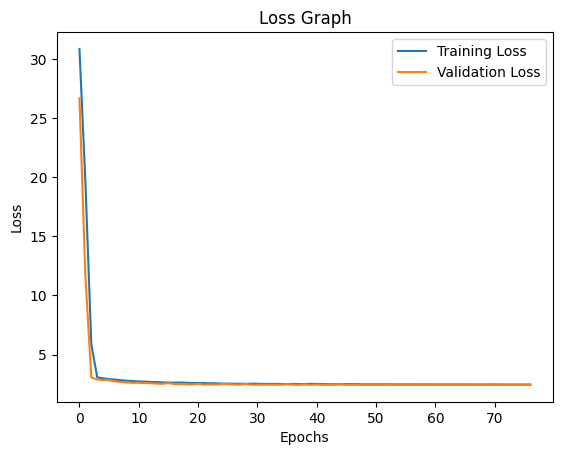

18/18 [==============================] - 0s 2ms/step - loss: 2.5267 - mae: 1.2346
Test MSE: 2.53
Test MAE: 1.23


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# 데이터 준비
X = df_cleaned.drop('Rings', axis=1)
y = df_cleaned['Rings']

# 데이터셋 분할 (훈련용/검증용/테스트용)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 전처리
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# 모델 정의
model = Sequential()
model.add(Dense(8, input_dim=X_train_processed.shape[1], activation='tanh'))
Dropout(0.3)
model.add(Dense(30, activation='tanh'))
model.add(Dense(30, activation='tanh'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 모델 학습
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train_processed, y_train, epochs=100, validation_data=(X_val_processed, y_val), batch_size=64, callbacks=[early_stopping,reduce_lr])

# 손실 그래프 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

# 테스트 데이터로 모델 최종 평가
test_loss, test_mae = model.evaluate(X_test_processed, y_test)
print(f"Test MSE: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")
